<center>
# Автовыделение интервалов коллектора по данным ГИС
<center>
В данном упражнении предлагается использовать все знания, полученные во время прохождения курса, для решения задачи автоматической интерпретации каротажных кривых.
## Описание кейса
На основе седиментологического описания одного из обнажений Шестаковского полигона, расположенного в Томской области, была построена синтетическая 3D геологическая модель.
<img src="img\Razrez.png">
При ее создании для повышения степени геологического реализма полученного результата в используемую структурную поверхность был внесен разлом, который разделяет модель в пропорции 1 к 4. Таким образом, с западной стороны от разлома структурная сетка содержит 324 ячейки, а с восточной - 1056. В каждой ячейке была создана синтетическая скважина и каротажные кривые, которые рассчитывались на основе априорных знаний о физических характеристиках тех или иных литологий и ячеек, которые пересекала скважина.

In [1]:
pip install lasio

  Using cached https://files.pythonhosted.org/packages/53/25/ef88e8e45db141faa9598fbf7ad0062df8f50f881a36ed6a0073e1572126/ordereddict-1.1.tar.gz
  Stored in directory: C:\Users\Burdinskiy\AppData\Local\pip\Cache\wheels\78\d3\a8\9f52c7a389a0ffba6f575a3886b5f7a55461fb6ec34aa5fd38
Successfully built ordereddict
Note: you may need to restart the kernel to use updated packages.


<center>
# Цель работы
Основная цель работы заключается в том, чтобы используя информацию по восточной части месторождения (1056 скважин) построить модель, которая сможет прогнозировать наличие или отсутствие коллектора в интервале в зависимости от показаний каротажных кривых. Далее, используя полученную модель, необходимо предсказать наличие или отсутствие коллектора для скважин, находящихся западнее от разлома (324).
<img src="img\NTG.png">

In [2]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
%matplotlib inline

In [3]:
# Загружаем данные тренировочной части
train_data = pd.DataFrame()
for file in listdir(r'data\train_test'):
    las_file = lasio.read(r'data\train_test\%s'%file).df().reset_index()
    las_file['Well'] = file[:-4]
    train_data = train_data.append(las_file, ignore_index = True)
train_data.columns = ['DEPT', 'SP', 'GR', 'DT', 'DENS', 'LITHO', 'Well']

In [4]:
train_data

DEPT          SP          GR          DT      DENS  LITHO     Well
0       2509.8  -92.088417   84.218269  314.000732  2.321674    1.0  208-901
1       2509.9  -86.453247   88.521309  311.837647  2.328126    1.0  208-901
2       2510.0  -83.557259   88.436943  311.839600  2.330478    0.0  208-901
3       2510.1  -82.992027   84.618828  313.684082  2.329336    0.0  208-901
4       2510.2  -85.293060   79.385338  316.232727  2.325939    1.0  208-901
5       2510.3  -90.079201   72.949646  319.379578  2.320608    1.0  208-901
6       2510.4  -92.587326   74.295891  318.568939  2.321832    1.0  208-901
7       2510.5  -93.027710   82.674324  314.181824  2.328983    1.0  208-901
8       2510.6  -89.214508   91.996086  309.121490  2.338070    0.0  208-901
9       2510.7  -81.455002  102.164688  303.450409  2.348933    0.0  208-901
10      2510.8  -73.914711  106.185745  299.659210  2.356599    0.0  208-901
11      2510.9  -66.597321  104.340401  297.657867  2.361216    0.0  208-901
12      2511.0  -62.609196  100.402092  295.610931  2.364901    0.0  208-901
13      2511.1  -61.887249   94.423233  293.516571  2.367681    0.0  208-901
14      2511.2  -60.941219   92.799202  292.439606  2.369111    0.0  208-901
15      2511.3  -59.756687   95.582443  292.396362  2.369172    0.0  208-901
16      2511.4  -57.028412  100.505608  293.394470  2.368220    0.0  208-901
17      2511.5  -52.689461  107.649834  295.477051  2.366218    0.0  208-901
18      2511.6  -49.031555  112.288444  296.786713  2.364870    0.0  208-901
19      2511.7  -46.109905  114.227997  297.262512  2.364226    0.0  208-901
20      2511.8  -44.070728  115.103531  297.393097  2.363462    0.0  208-901
21      2511.9  -43.008919  114.803619  297.143524  2.362566    0.0  208-901
22      2512.0  -42.215286  114.519539  297.016541  2.361914    0.0  208-901
23      2512.1  -41.726040  114.254082  297.028870  2.361545    0.0  208-901
24      2512.2  -41.247833  114.284447  297.191101  2.360825    0.0  208-901
25      2512.3  -40.782913  114.662781  297.529907  2.359690    0.0  208-901
26      2512.4  -40.412849  115.107010  297.993286  2.358219    0.0  208-901
27      2512.5  -40.158596  115.629692  298.607819  2.356342    0.0  208-901
28      2512.6  -39.978016  115.977898  299.039215  2.355219    0.0  208-901
29      2512.7  -39.889744  116.107781  299.239868  2.355042    0.0  208-901
...        ...         ...         ...         ...       ...    ...      ...
203069  2507.6 -110.249825   69.119446  311.656220  2.329886    0.0  244-924
203070  2507.7 -108.272041   71.952675  303.594116  2.347288    0.0  244-924
203071  2507.8 -106.529854   72.959534  298.384308  2.359657    0.0  244-924
203072  2507.9 -104.970772   72.577331  295.355957  2.368172    0.0  244-924
203073  2508.0 -104.332123   71.054100  297.084625  2.366583    0.0  244-924
203074  2508.1 -104.387672   68.669907  302.404297  2.357363    0.0  244-924
203075  2508.2 -102.909866   67.792084  304.701904  2.353467    1.0  244-924
203076  2508.3 -100.273941   68.052643  304.710419  2.353610    1.0  244-924
203077  2508.4  -95.342629   70.270332  301.353729  2.359742    0.0  244-924
203078  2508.5  -88.700348   73.944817  295.500641  2.370309    0.0  244-924
203079  2508.6  -81.189446   78.843254  292.839477  2.374171    0.0  244-924
203080  2508.7  -73.028084   84.662186  292.574493  2.373002    0.0  244-924
203081  2508.8  -66.617241   90.350876  293.445892  2.370137    0.0  244-924
203082  2508.9  -61.518047   95.935593  295.154938  2.366026    0.0  244-924
203083  2509.0  -60.537495   97.698418  295.105102  2.365531    0.0  244-924
203084  2509.1  -62.607422   96.626328  293.752991  2.367711    0.0  244-924
203085  2509.2  -65.736992   95.302757  294.002441  2.366822    0.0  244-924
203086  2509.3  -69.637253   93.809105  295.440613  2.363653    0.0  244-924
203087  2509.4  -73.276237   91.868553  299.560028  2.355744    0.0  244-924
203088  2509.5  -76.729469   89.585419  305.634460  2.344380    0.0  244-924
203089

<center>

## Описание данных

Файл с тренировочными данными содержит информацию по 1056 скважинам, находящимся восточнее разлома. Каждая скважина представлена 4 каротажными кривыми:

- **SP** (каротаж естественной поляризации)
- **GR** (гамма каротаж)
- **DT** (акустический каротаж)
- **Density** (плотностной каротаж)

В качестве кривой РИГИС выступает дискретный каротаж **LITHO**, который при значении "1" говорит о наличие коллектора, а при значении "0" о его отсутствии.

<center>
##### Статистическая оценка

В этом блоке мы поближе изучим данные со статистической точки зрения.

In [5]:
# Посмотрим, какие типы данных представлены в загруженном файле и есть ли в нем пропуски
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203099 entries, 0 to 203098
Data columns (total 7 columns):
DEPT     203099 non-null float64
SP       203099 non-null float64
GR       203099 non-null float64
DT       203099 non-null float64
DENS     203099 non-null float64
LITHO    203099 non-null float64
Well     203099 non-null object
dtypes: float64(6), object(1)
memory usage: 10.8+ MB


In [6]:
# Посмотрим статистику по данным

train_data.describe()

DEPT             SP             GR             DT  \
count  203099.000000  203099.000000  203099.000000  203099.000000   
mean     2514.029415     -77.407355      90.875375     307.165724   
std         9.306925      27.588862      19.810404      11.667743   
min      2485.100000    -125.710487      57.799000     283.392731   
25%      2507.800000    -102.279652      71.676132     297.902679   
50%      2514.900000     -72.802902      93.382996     303.161560   
75%      2521.000000     -52.256079     111.070805     316.708115   
max      2543.700000     -38.943268     116.989639     330.196503   

                DENS          LITHO  
count  203099.000000  203099.000000  
mean        2.342216       0.323414  
std         0.022138       0.467780  
min         2.295403       0.000000  
25%         2.324109       0.000000  
50%         2.349329       0.000000  
75%         2.359741       1.000000  
max         2.390461       1.000000

**Задание №1**.

Здесь Вам предлагается посчитать статистические характеристики для представленных данных. Используя стандартные методы библиотеки **pandas** (фильтрация и **median**), определите медианные значения каротажей SP и GR для разностей коллектора и неколлектора.

Далее, используя метод **corr** библиотеки **pandas**, определите коэффициенты корреляции Пирсона для всех каротажных кривых.

In [7]:
# Ваш код здесь
collector_exist_part = train_data[train_data['LITHO'] == 1]
collector_exist_part.describe()


DEPT            SP            GR            DT          DENS  \
count  65685.000000  65685.000000  65685.000000  65685.000000  65685.000000   
mean    2516.954886   -106.895560     69.176841    321.071640      2.316149   
std        8.088452     16.130024     10.174357      6.784200      0.013067   
min     2485.700000   -125.710487     57.799000    296.502716      2.295403   
25%     2512.300000   -120.714020     60.765537    316.033569      2.305019   
50%     2517.700000   -111.523499     65.083077    323.051849      2.312529   
75%     2522.500000    -96.128578     75.824341    327.118591      2.325843   
max     2543.700000    -51.742474    106.203720    330.196503      2.364369   

         LITHO  
count  65685.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

In [8]:
collector_no_exist_part = train_data[train_data['LITHO'] == 0]
collector_no_exist_part.describe()

DEPT             SP             GR             DT  \
count  137414.000000  137414.000000  137414.000000  137414.000000   
mean     2512.631016     -63.311755     101.247449     300.518584   
std         9.523897      19.653783      14.068610       6.526145   
min      2485.100000    -125.150154      61.662666     283.392731   
25%      2506.100000     -75.424841      92.096771     297.156464   
50%      2512.900000     -58.832745     104.971855     298.613541   
75%      2520.000000     -46.830297     114.137758     303.564850   
max      2542.500000     -38.943268     116.989639     326.635010   

                DENS     LITHO  
count  137414.000000  137414.0  
mean        2.354676       0.0  
std         0.012755       0.0  
min         2.304919       0.0  
25%         2.348472       0.0  
50%         2.357482       0.0  
75%         2.362042       0.0  
max         2.390461       0.0

In [9]:
train_data_corr = train_data.corr(method='pearson')  
train_data_corr

DEPT        SP        GR        DT      DENS     LITHO
DEPT   1.000000 -0.326398 -0.303667  0.267074 -0.263668  0.217324
SP    -0.326398  1.000000  0.968731 -0.847788  0.836724 -0.738981
GR    -0.303667  0.968731  1.000000 -0.828245  0.814779 -0.757279
DT     0.267074 -0.847788 -0.828245  1.000000 -0.981370  0.824008
DENS  -0.263668  0.836724  0.814779 -0.981370  1.000000 -0.814091
LITHO  0.217324 -0.738981 -0.757279  0.824008 -0.814091  1.000000

<center>
##### Визуальная оценка

Ниже будет проведена визуальная оценка данных с целью найти какие-либо зависимости в данных для лучшего их понимания.

In [10]:
# Проведем визуальную оценку имеющийся информации
target_logs = [log for log in train_data.columns if log not in ['LITHO', 'Well', 'DEPT']]
sns.pairplot(train_data, vars = target_logs, hue = 'LITHO', palette = ['brown', 'gold'])

**Задание №2**.

Здесь Вам предлагается,  используя библиотеку **seaborn**, построить **heatmap** ранее посчитанной корреляционной матрицы по имеющемуся набору данных.

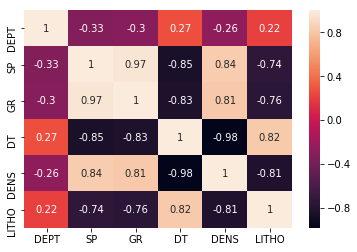

In [11]:
# Ваш код здесь
sns.heatmap(train_data_corr, annot = True)

<center>
## Генерация дополнительных признаков (опционально)
Как известно, чем больше информации мы имеем, тем более полно мы можем описать систему, порождающую то или иное распределение. В данном блоке Вам предлагается попробовать построить какие-либо новые признаки на основе уже имеющихся, которые помогли бы в построении более сложной и качественной модели.

Например, Вы можете использовать данные о расположении скважины как дополнительный признак, взять логарифмические или степенные функции каротажей, а также посчитать их производные.

Если Вы чувствуете, что Ваших знаний языка Python недостаточно, то этот шаг можно пропустить.

In [12]:
# Ваш код здесь


def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)

<center>
## Подготовка данных и построение базовой модели
В представленном задании перед слушателем стоит 2 цели - индивидуальная и участие в соревновании среди слушателей.

Индивидуальной целью является победа над имеющейся простейшей моделью на тестовом наборе данных.

Соревновательная цель заключается в участии в соревновании среди всех слушателей, во время которого от Вас требуется показать наилучший результат предсказания распределения интервалов коллектора на скрытом наборе данных (скважины находящиеся западнее разлома).

В блоках ниже расположен код, отвечающий за разбитие данных на тренировочную и тестовую части, а также построение базовой модели с последующей оценкой ее качества.

In [13]:
# Разобьем данные на тренировочную и тестовую части в пропорции 0.7 и 0.3 соответственно

train_part_size = 0.7

# Случайно выберем скважины для тренировочного и тестового наборов
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(len(train_data.Well.unique())*train_part_size))
train_set = train_data.loc[train_data.Well.isin(train_wells)]
test_set = train_data.loc[train_data.Well.isin(i for i in train_data.Well.unique() if i not in train_wells)]

In [14]:
# Разобьем данные тренировочной и тестовой частей на матрицу признаков и вектор классов

Feature_train = train_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1)
Target_train = train_set['LITHO']

Feature_test = test_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1)
Target_test = test_set['LITHO']

In [15]:
# Здесь мы для предсказания будем использовать одну из самых простых моделей - Метод ближайшего соседа
# Полученная точность будет взята за планку, которую необходимо побить
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Feature_train, Target_train)
predicted_litho = clf.predict(Feature_test)

In [16]:
# Посчитаем точность полученную нашей baseline-моделью
# Считаться будут две метрики - F1 и Accuracy
base_acc = accuracy_score(Target_test, predicted_litho)
base_f1 = f1_score(Target_test, predicted_litho)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для базового кейса.'%(base_f1, base_acc))

F1 метрика равна 0.850, и доля правильных ответов составляет 0.902 для базового кейса.


<center>

# Построение модели

**Задание №3**.

Загрузив все необходимые данные, проведя их их предварительную обработку и получив первые предсказания, можно перейти непосредственно к построению собственной модели.
В ячейке ниже создайте свою модель, которая будет называться **user_clf**, предварительно импортировав необходимые библиотеки.
После чего получите с ее помощью предсказание для тестовой части набора **Feature_test**, назвав переменную, хранящую предсказание, именем **user_prediction**.

Вам необходимо выбрать такую модель, которая показала бы более высокую точность предсказания, чем модель в ячейках выше.

In [17]:
# Ваш код здесь
train_part_size = 0.80

# Случайно выберем скважины для тренировочного и тестового наборов
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(len(train_data.Well.unique())*train_part_size))
train_set = train_data.loc[train_data.Well.isin(train_wells)]
test_set = train_data.loc[train_data.Well.isin(i for i in train_data.Well.unique() if i not in train_wells)]


In [18]:
# Разобьем данные тренировочной и тестовой частей на матрицу признаков и вектор классов

Feature_train = getPreprocessing(train_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1))
Target_train = train_set['LITHO']

Feature_test = getPreprocessing(test_set.drop(['DEPT', 'Well', 'LITHO'], axis = 1))
Target_test = test_set['LITHO']

In [19]:
from catboost import CatBoostClassifier

user_clf = CatBoostClassifier(iterations=200, depth=5, learning_rate=1, loss_function='Logloss', logging_level='Verbose')
#train the model
user_clf.fit(Feature_train, Target_train)
# make the prediction using the resulting model
user_prediction = user_clf.predict(Feature_test)

0:	learn: 0.1913811	total: 213ms	remaining: 42.4s
1:	learn: 0.1725894	total: 302ms	remaining: 29.9s
2:	learn: 0.1668250	total: 428ms	remaining: 28.1s
3:	learn: 0.1626609	total: 549ms	remaining: 26.9s
4:	learn: 0.1597423	total: 654ms	remaining: 25.5s
5:	learn: 0.1567307	total: 776ms	remaining: 25.1s
6:	learn: 0.1554275	total: 898ms	remaining: 24.8s
7:	learn: 0.1542392	total: 1s	remaining: 24.1s
8:	learn: 0.1533585	total: 1.09s	remaining: 23.2s
9:	learn: 0.1525087	total: 1.21s	remaining: 23.1s
10:	learn: 0.1521245	total: 1.33s	remaining: 22.8s
11:	learn: 0.1512804	total: 1.42s	remaining: 22.3s
12:	learn: 0.1505974	total: 1.52s	remaining: 21.9s
13:	learn: 0.1498684	total: 1.62s	remaining: 21.5s
14:	learn: 0.1493328	total: 1.71s	remaining: 21.1s
15:	learn: 0.1486104	total: 1.82s	remaining: 21s
16:	learn: 0.1481674	total: 1.92s	remaining: 20.7s
17:	learn: 0.1477261	total: 2.02s	remaining: 20.5s
18:	learn: 0.1472061	total: 2.14s	remaining: 20.4s
19:	learn: 0.1466034	total: 2.25s	remaining: 2

161:	learn: 0.1313246	total: 17.6s	remaining: 4.12s
162:	learn: 0.1312569	total: 17.7s	remaining: 4.01s
163:	learn: 0.1312207	total: 17.8s	remaining: 3.9s
164:	learn: 0.1311702	total: 17.9s	remaining: 3.79s
165:	learn: 0.1311087	total: 18s	remaining: 3.68s
166:	learn: 0.1310540	total: 18.1s	remaining: 3.57s
167:	learn: 0.1310138	total: 18.2s	remaining: 3.46s
168:	learn: 0.1309726	total: 18.3s	remaining: 3.35s
169:	learn: 0.1308722	total: 18.4s	remaining: 3.24s
170:	learn: 0.1308303	total: 18.5s	remaining: 3.13s
171:	learn: 0.1307478	total: 18.6s	remaining: 3.02s
172:	learn: 0.1306890	total: 18.7s	remaining: 2.92s
173:	learn: 0.1306258	total: 18.8s	remaining: 2.81s
174:	learn: 0.1305872	total: 18.9s	remaining: 2.7s
175:	learn: 0.1305529	total: 19s	remaining: 2.59s
176:	learn: 0.1304977	total: 19.1s	remaining: 2.48s
177:	learn: 0.1304333	total: 19.2s	remaining: 2.38s
178:	learn: 0.1303882	total: 19.3s	remaining: 2.27s
179:	learn: 0.1303586	total: 19.4s	remaining: 2.16s
180:	learn: 0.1303

In [20]:
# Посчитаем точность полученную моделью слушателя
# Считаться будут две метрики - F1 и Accuracy
user_acc = accuracy_score(Target_test, user_prediction)
user_f1 = f1_score(Target_test, user_prediction)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для модели слушателя.'%
      (user_f1, user_acc))

F1 метрика равна 0.883, и доля правильных ответов составляет 0.925 для модели слушателя.


<center>
# Предсказание по скрытым скважинам (соревновательная часть)
На данный момент Вы уже имеете наилучшую на Ваш взгляд модель. Теперь ее можно использовать для предсказания распределения интервалов коллектора на скрытой части данных. В дальнейшем предсказание каждого слушателя будет проверено по имеющимся реальным меткам коллектора и оценено соответствующими метриками. 
Все участники узнают точность своего предсказания только в конце соревнования, когда будет получен сводный итог.

От Вас требуется лишь запустить блок ниже, результат автоматически будет загружен на сервер.

**P. S.**

Если Вы создавали дополнительные признаки на основе уже имеющихся, то Вам необходимо будет также создать их и для той части данных, которая ранее была скрыта.

In [88]:
# В переменную user_name введите свою фамилию и инициалы, как в примере ниже
user_name = 'BurdinskiyVA'

In [89]:
# Загружаем данные каротажей по скрытым скважинам и предобрабатываем их
validation_data = pd.read_csv('data\Shestakovo_validation.csv')
Feature_valid = getPreprocessing(validation_data.drop(['Well', 'DEPT'], axis = 1))
valid_predict = pd.Series(user_clf.predict(Feature_valid), name='%s_prediction'%user_name)
valid_predict.to_csv('%s_prediction.csv'%user_name, index = None)